# Advanced KNN  
**Author:** Aman (Documenting my ML learning journey)

"""
In this notebook, I am taking my understanding of **K-Nearest Neighbors (KNN)** to the next level.  
In my previous notebook, I implemented and explained the basics of KNN for classification.  

But knowing how to just "use" KNN is not enough — I want to **really understand** its inner workings,  
its limitations, and when to use it (or avoid it!) in real-world ML projects.

So here, I will:
- Recap KNN briefly
- Explore KNN Regressor (yes, KNN is not just for classification!)
- Dive into its hyperparameters and their effects
- Learn about weighted KNN
- Experiment with different distance metrics
- Discuss scaling, complexity, and speedups (kd-tree, ball-tree)
- Talk about challenges like imbalanced data and curse of dimensionality
- Reflect on what I learned and when I’d actually use KNN in practice
"""


# Quick Recap of what KNN does

In my basic KNN notebook, I learned that KNN is a **lazy learner**:
- It doesn’t build a traditional "model" during training.
- It just stores the training data.
- When a new data point comes, it finds the **k nearest neighbors** and predicts based on majority vote (classification) or average (regression).

This was good to build **intuition**, but now I want to look at more **practical, advanced topics** like regression, distance metrics, scaling, and performance.


# KNN for Regression (KNeighborsRegressor)

Yes, KNN can also be used for **regression** problems where the output is continuous.  
Instead of taking a majority vote, KNN regressor takes the **average of the k nearest neighbors' target values**.

This is super intuitive — if you want to predict the house price in a new area,  
you look at the prices of k most similar houses nearby and take the average.  
That's exactly what KNN regression does.


**Simple KNN Regressor**

In [1]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# synthetic regression data (1 feature so we can visualize easily)
X, y = make_regression(n_samples=100, n_features=1, noise=15, random_state=42)

In [3]:
# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# train a KNN Regressor
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

KNeighborsRegressor()

In [6]:
# Predictions
y_pred = knn_reg.predict(X_test)

In [9]:
# evaluate
print(" Mean Squared Error:", mean_squared_error(y_test, y_pred))
print(" R² Score:", r2_score(y_test, y_pred))

 Mean Squared Error: 239.813691338355
 R² Score: 0.8713245407583777


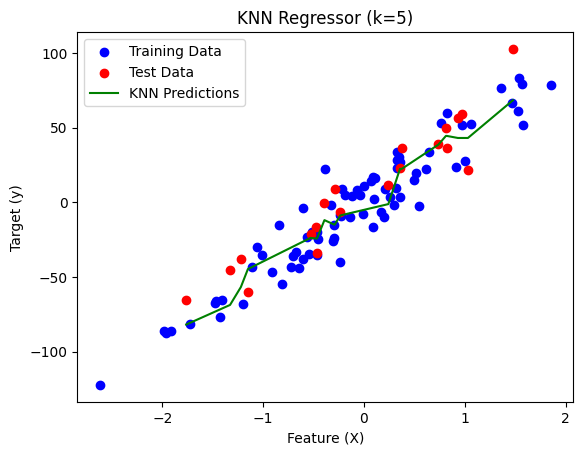

In [10]:
# Visualization
# Sort values for a smooth line
sorted_idx = np.argsort(X_test.flatten())
plt.scatter(X_train, y_train, color="blue", label="Training Data")
plt.scatter(X_test, y_test, color="red", label="Test Data")
plt.plot(X_test[sorted_idx], y_pred[sorted_idx], color="green", label="KNN Predictions")
plt.title("KNN Regressor (k=5)")
plt.xlabel("Feature (X)")
plt.ylabel("Target (y)")
plt.legend()
plt.show()

# My Takeaways

- KNN regressor is **super simple** but surprisingly powerful for small, smooth datasets.
- I can clearly see how the prediction line is "piecewise" — it’s not a perfect curve but adjusts based on local neighbors.
- The choice of k matters a lot:
  - Small k (say 1)→ very wiggly prediction (can overfit).
  - Large k (say n(Total data point))→ smoother prediction (can underfit).

I love this experiment because I can **see** the effect visually — this helps me truly "get it."

# Understanding KNN Hyperparameters

KNN is a very "parameter-driven" algorithm — its performance can change drastically depending on a few key choices.  
Here are the most important hyperparameters you should know:

- **n_neighbors (k):** Number of neighbors to consider.  
- **weights:** How to weight neighbors — equally or based on distance.  
- **p:** Power parameter for the distance metric  
  - p=2 → Euclidean Distance  
  - p=1 → Manhattan Distance  
- **algorithm:** This decides how the neighbors are actually searched under the hood.  
  - **brute:** Compares every point one by one (slow for large datasets).  
  - **kd_tree / ball_tree:** Use clever tree data structures to make neighbor search faster — works best in low to medium dimensions.  
  - **auto:** Lets sklearn pick the best option for you (safe default).  

- **leaf_size:** A tuning parameter that controls how deep the kd-tree or ball-tree is built.  
  - Smaller leaf_size → deeper tree (faster query, but more memory).  
  - Larger leaf_size → shallower tree (less memory, slower query).  
  - Honestly, I usually leave this to the default unless I am optimizing for speed.


**Experiment 1 : Effect of K (n_neighbours)**

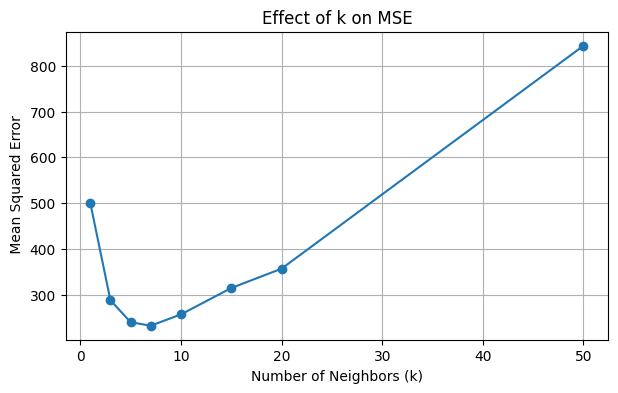

In [13]:
from sklearn.metrics import mean_squared_error

K_values = [1,3,5,7,10,15,20,50]
mse_scores = []

for k in K_values :
  knn_reg = KNeighborsRegressor(n_neighbors= k)
  knn_reg.fit(X_train ,y_train)
  y_pred = knn_reg.predict(X_test)
  mse_scores.append(mean_squared_error(y_test ,y_pred))

# plot
plt.figure(figsize = (7,4))
plt.plot(K_values ,mse_scores ,marker= 'o')
plt.title("Effect of k on MSE")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel(" Mean Squared Error")
plt.grid()
plt.show()

# My Thoughts on Choosing k

- When **k is very small (e.g. 1)**, the model becomes very sensitive to noise → low bias, high variance (Overfitting).
- When **k is very large**, the model becomes too smooth → high bias, low variance (Underfitting).
- This is basically the **bias-variance tradeoff** in action!  
- I will use either cross-validation or this kind of plot to pick the "sweet spot" for k.

**Experiment 2: Uniform vs Distance Weights**

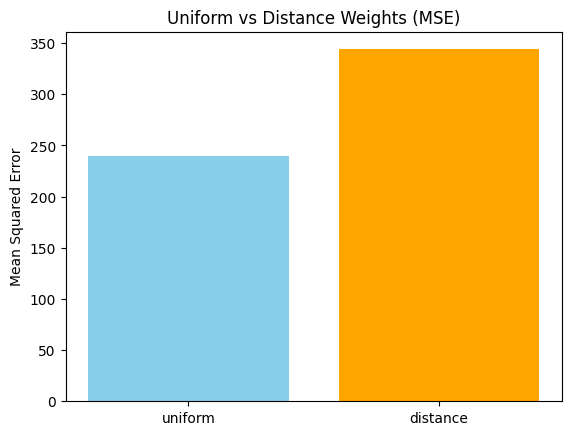

In [14]:
weights_options = ['uniform', 'distance']
mse_weighted = []

for w in weights_options:
    knn_reg = KNeighborsRegressor(n_neighbors=5, weights=w)
    knn_reg.fit(X_train, y_train)
    y_pred = knn_reg.predict(X_test)
    mse_weighted.append(mean_squared_error(y_test, y_pred))

plt.bar(weights_options, mse_weighted, color=['skyblue','orange'])
plt.title("Uniform vs Distance Weights (MSE)")
plt.ylabel("Mean Squared Error")
plt.show()

# Intuition about Weights

- **Uniform weights:** Here all neighbors are treated equally, no matter how far they are.
- **Distance weights:** Closer neighbors have **more influence** than far ones.
- This makes sense in real life — if I am predicting house prices, houses closer to my target should matter more.
- In many datasets, distance-weighted KNN performs better. But I always try both to see which one fits better.

**Experiment 3: Distance Metrics (p=1 vs p=2)**

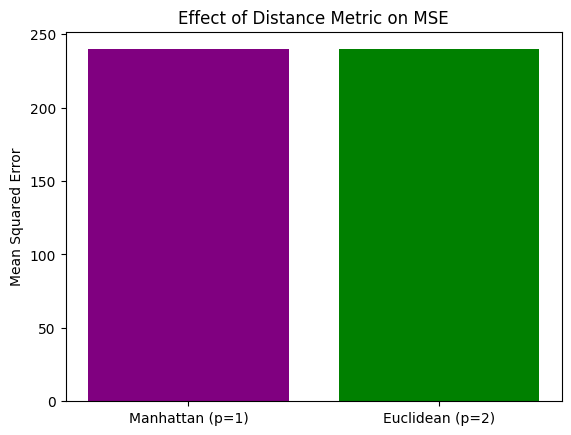

In [15]:
p_values = [1, 2]  # Manhattan vs Euclidean : if p = 1 (Manhattan) , p = 2 (Euclidean)
mse_p = []

for p in p_values:
    knn_reg = KNeighborsRegressor(n_neighbors=5, p=p)
    knn_reg.fit(X_train, y_train)
    y_pred = knn_reg.predict(X_test)
    mse_p.append(mean_squared_error(y_test, y_pred))

plt.bar(['Manhattan (p=1)', 'Euclidean (p=2)'], mse_p, color=['purple','green'])
plt.title("Effect of Distance Metric on MSE")
plt.ylabel("Mean Squared Error")
plt.show()

# When to Use Which Distance Metric?

- **Euclidean (p=2):** Best when features are continuous and data is well-scaled.
- **Manhattan (p=1):** Better for high-dimensional or sparse data, because it is less sensitive to outliers.
- Example: In a grid-like city (like Manhattan (Idea from where Manhattan distance came from ), you can't walk diagonally → so Manhattan distance makes sense there.

# My Key Takeaways So Far

1. KNN is **not a "set and forget" algorithm** — tuning k, weights, and distance metric really matters.
2. Picking k is like finding a balance between **underfitting** and **overfitting**.
3. Distance-weighted KNN often performs better in practice, because closer neighbors should count more.
4. Choice of distance metric depends on data type and scale — I will always scale data before using KNN.

This section made me realize why hyperparameter tuning (GridSearchCV, RandomizedSearchCV) is not optional for KNN — it’s necessary!